# DenseAutoencoder AnomalyDetection MNISTdataset

We have seen how to implement an Autoencoder. Now we use it for a specific usefult application: anomaly detection.

### Anomaly detection

We have our set of data. Our data have a certain distribution. Which is basically the data manifold.

An anomaly (or outlier) is an instance which is outside this distribution. It is a strange point of our distribution.
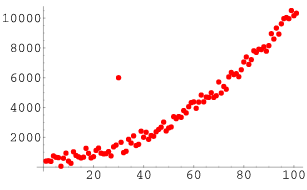

Anomaly detection consists in, given an instance, detect if it is an anomaly or not.

## USING AN AUTOENCODER FOR ANOMALY DETECTION

Let's see how to use an autoencoder for anomaly detection.

We have our trained autoencoder, and we want to perform anomaly detection.

### Step 1: compute some statistics on the test data

We take our test data $x_{test}$.

We take an image $x$ in the test set. We apply the autoencoder: reconstructed image $\hat{x}$. We compute a distance measure between $x$ and $\hat{x}$ (e.g. MSE): we have a single error value.

We do that for all the images in the test set. For each test image, we get a MSE value error. We compute some statistics on these error values, like the mean $\mu$ and the std $\sigma$.

Note: this step could be done also in the training set $x_{train}$.

### Step 2: anomaly detection

We have a new instance $x$. We want to understand if it is an anomaly or not.

We apply the autoencoder: we get the reconstructed imahe $\hat{x}$. We compute the MSE between $x$  and $\hat{x}$. Let this error value be $e$.

Now we compare $e$ with the mean $\mu$.
- If $e$ is very close to $\mu$ (i.e. $\mu-3*\sigma<=e<=\mu+3*\sigma$) then $x$ is not an anomaly
- Otherwise, if $e$ is far from $\mu$, then $x$ is an anomaly.

### Why does this work?

This works because our Autoencoder is very data-specific. It works well only with instances taken from our dataset, taken from the distribution of the data. If we take an instance outside the distribution, the Autoencoder does not work well.

An outlier can be seen as an instance outside our dataset. Outside the distribution of the datat. Strange instance.

So, given an instance $x$:
- If the reconstruction error $e = MSE(x,\hat{x})$ is small, then $\hat{x}$ is a good reconstruction of $x$:  $x$  is not an anomaly (it is in the distribution of the data).
- Otherwise, if the reconstruction error $e$ is big, then $\hat{x}$ is a bad reconstruction of $x$: $x$ is an anomaly (it's not in the distribution of the data).

## ANOMALY DETECTION ON THE MNIST DATASET

Anomaly detection on the MNIST dataset, by means of a Dense AUtoencoder.

In [19]:
from tensorflow.keras.layers import Input, Dense, Flatten  # Classic layers

from tensorflow.keras.models import Model  

from tensorflow.keras.datasets import mnist  # MNIST dataset

import matplotlib.pyplot as plt

import numpy as np

### Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('There are {} samples in the training set'.format(x_train.shape[0]))
print('There are {} samples in the test set'.format(x_test.shape[0]))

There are 60000 samples in the training set
There are 10000 samples in the test set


Normalization

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Flattening. We have to flatten the input $x$ beacuse we work with Dense layers.

In [5]:
# Flattening each image in the training set
x_train = np.reshape(x_train, (60000,28*28)) 

# Flattening each image in the test set
x_test = np.reshape(x_test, (10000,28*28))

### Autoencoder

Exact same Dense autoencoder seen before.

In [6]:
### INPUT
xin = Input(shape=(784,))

### ENCODER
x = Dense(units=64, activation='relu')(xin)
z = Dense(units=16, activation='relu')(x) # Latent encoding z

### DECODER
x = Dense(units=64, activation='relu')(z)
xout = Dense(units=784, activation='sigmoid')(x) # Reconstructed image

### MODEL
autoencoder = Model(inputs=xin, outputs=xout)

In [7]:
from tensorflow.keras.optimizers import Adam  # We import the optimizer
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [8]:
autoencoder.fit(x_train, x_train, epochs=20, batch_size=256, validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 2s 6ms/step - loss: 0.0696 - val_loss: 0.0440
Epoch 2/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0384 - val_loss: 0.0333
Epoch 3/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0301 - val_loss: 0.0263
Epoch 4/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0252 - val_loss: 0.0236
Epoch 5/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0233 - val_loss: 0.0224
Epoch 6/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0222 - val_loss: 0.0214
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0216 - val_loss: 0.0209
Epoch 8/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 9/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0206 - val_loss: 0.0199
Epoch 10/20
235/235 [==============================] - 1s 5ms/step - loss: 0.0201 - val_loss: 0.0194

### Step 1: computing the statistics on the test set

In [11]:
# Reconstructed test images
x_test_hat = autoencoder.predict(x_test)

In [15]:
# MSE error value for each instance in the test set
mse_list = np.mean(np.square(x_test_hat - x_test), axis=1) 

# Mean
mu = np.mean(mse_list)
# Std
std = np.std(mse_list)

print("Mean is {}, with a standard deviation of {}".format(mu,std))

Mean is 0.0169821847230196, with a standard deviation of 0.009071693755686283


### Detecting a normal instance (no anomaly)

First of all, let's take an image in the dataset. So, not an anomaly. We take the $15$-th test instance.

MSE value: 0.024777642


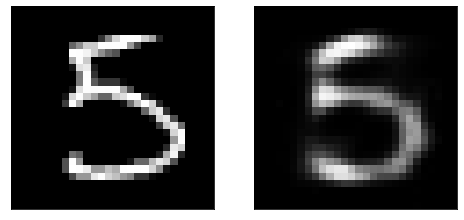

In [21]:
x = x_test[15].reshape(1,784)

x_hat = autoencoder.predict(x)

mse = np.mean(np.square(x - x_hat), axis=1)[0]
print('MSE value:', mse)

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plt.imshow(x.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(x_hat.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('lyar1.jpg')
plt.show()

**The reconstruction is quite good!** This beacuse the image is in the distribution of the data.

The MSE value $0.024777642$ is quite close to the mean $\mu$ $0.0169821847230196$.

In [22]:
abs(mse-mu)

0.007795457

The difference is less than one std $\sigma=0.009071693755686283$.

**So, we detect that as a normal instance (no anomaly)**

### Detecting an anomaly

We create an anomaly by rotating an image. We take the same instance of before, but now we rotate it, by $90^°$.

In [25]:
x = np.rot90(x_test[15].reshape(28,28)).reshape(1,784)

MSE value: 0.051033195


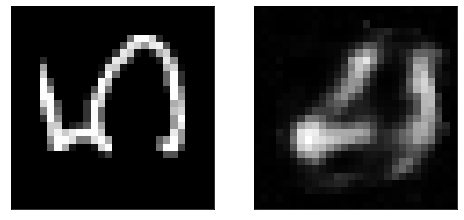

In [27]:
x_hat = autoencoder.predict(x)

mse = np.mean(np.square(x - x_hat), axis=1)[0]
print('MSE value:', mse)

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plt.imshow(x.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(x_hat.reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('lyar1.jpg')
plt.show()

**The reconstruction is quite bad!!!** This because this image is pretty different from the other images. It is pretty outisde the distribution of the data.

The MSE value $0.051033195$ is quite far from the mean $\mu$ $0.0169821847230196$.

In [28]:
abs(mse-mu)

0.03405101

The difference is bigger than three std $\sigma=0.009071693755686283$.

**So, we detect that as an anomaly!**

### FINAL REMARK

An alternative approach of doing anomaly detection with autoencoders is to work with the latent space, instead of the reconstructed images.

This because an anomaly instance $x$ in the data manifold will have also an anomaly latent encoding $z$ in the latent space.